# Transport through 1D quantum well structures, Python edition
This is a Python version of the 1D quantum transport mathematica notebook. It's a bit longer than the Mathematica version but that is largely due to more commentary, examples and more plots.

Under the 'tips and tricks' section, you can find some basic tricks on notebooks and plot interactivity.

The solution to the exercise uses a lot of somewhat special Python syntax/features (as compared to other languages), but try to see if you can make sense of it yourself, possibly googling some details (eg. "double asterisk in python"), and otherwise feel free to ask.

Any notebook should start with the imports. Numpy is the "standard" library for numerics, matplotlib for plotting, and the rest is for notebook interactivity. Many more libraries exist. For example, the library `sympy` exists for symbolic math manipulations. It is however not as good as Mathematica or Maple for that. Where Python is far superior is for writing 'regular' code, plots etc, which comes in handy when sharing code both between projects and other people. Also, it is free (for everyone, not just dtu students).

Shortcuts: 

* [Tips and tricks](#tipstricks)
* [Start of implementation for the actual exercise](#exercise)
* [Single barrier](#bar1)
* [Double barrier](#bar2)
* [Double well](#well2)
* [Multi well](#multiwell)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import concurrent

In [3]:
from ipywidgets import interactive
from IPython.display import display

In [4]:
%matplotlib widget

In [5]:
# %matplotlib notebook
# Make the plots interactive. The default, 'inline', just shows the plots as images.
# In jupyter notebooks (not jupyter lab), this needs its own cell. It will not work if put alongside the imports.
# When using jupyter lab, you may want to use `%matplotlib ipympl` instead.


## Tips and tricks <a name="tipstricks"></a>
* Look through the keyboard shortcuts. They will be of great advantage. "a" inserts a cell above, "b" a cell below, "d-d" deletes a cell, "m" converts to markdown cell, "Y" converts to code cell, etc.
* Make a new cell and type `?np.linalg.inv`. An in-page 'sub-window' will appear with the help documentation for the matrix inverse function. This works with *all* objects (just put the question mark in front). On some occasions this is easier than googling.
* When you've made a large program and wonder what is taking so long, you can use the 'magic commands' %time and %timeit for profiling. %time just shows how long it took to run the command. %timeit runs your command a number of times and shows you the average running time. There are many more magic commands, you could google them!
* If something breaks and you don't know why, there are a few common techniques: Loads of print statements and commenting out code. Another technique is to put `breakpoint()` into your code where appropriate. It stops your code and opens an interactive prompt at that place, where you can then inspect variables etc.

### Super quickie on Python in jupyter notebooks

You can execute Python code that you write directly, as shown below:

In [6]:
my_variable = np.linspace(0, 1, 5)
my_variable *= 2
print("my_variable:", my_variable)
my_matrix = np.array([[0, 1], [2, 3]])
print("my_matrix dot a vector:", my_matrix.dot([1, 2]))

my_variable: [0.  0.5 1.  1.5 2. ]
my_matrix dot a vector: [2 8]


In [7]:
np.dot(np.array([1,2]),np.array([3,4]))

11

You can also make plots, like so:

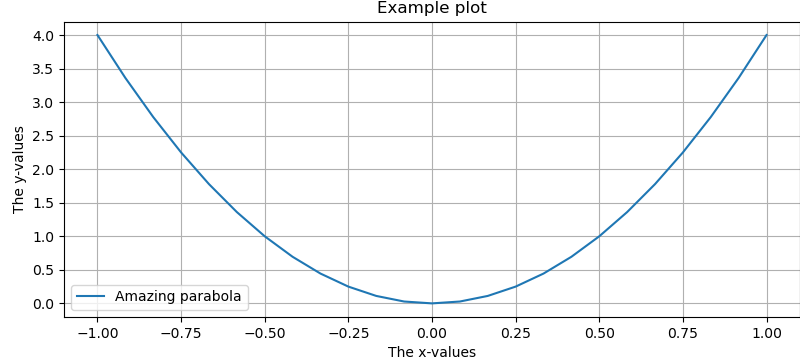

In [8]:
x = np.linspace(-1, 1, 25)
y = 4 * x**2

fig, ax = plt.subplots(  # Create figure and ax
    figsize=(8, 3.6),  # Optional: Specify figure size
    gridspec_kw=dict(  # Optional: Specify some extra details
        left=0.08, right=1, top=0.94, bottom=0.12
    )
)
ax.plot(x, y, label="Amazing parabola")  # Plot some x and y values into the axes that we made
ax.legend()  # Add a legend: Placement is automatic but can be specified
ax.grid(True)  # Draw grid
ax.set_xlabel("The x-values")
ax.set_ylabel("The y-values")
ax.set_title("Example plot")
plt.show()  # Show the figure

Note that it is generally better to put your problem to be solved into a function. That way, if you need to solve the problem again, but just for some different values, you don't have to copy-paste the entire thing or go back and edit the previous one. Here we show an "advanced" example for an interactive plot.

interactive(children=(FloatSlider(value=5.1, description='special_parameter', max=10.1, min=0.1), Checkbox(val…

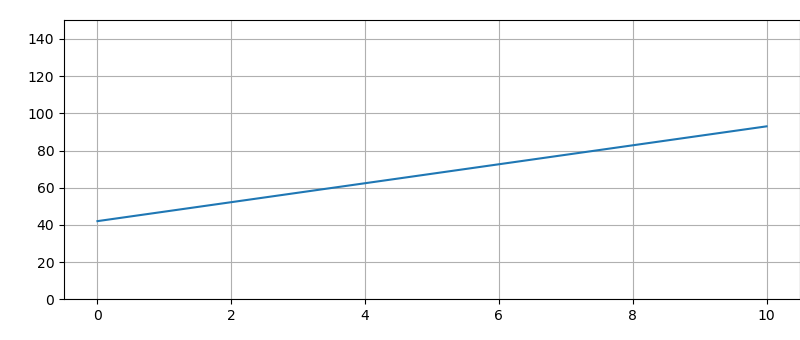

In [9]:
def my_advanced_function(x, special_parameter, is_that_thing_turned_on=False):
    """Say this is where you solve the 'mathematical' problem you are given. We just do some mock stuff for now."""
    if is_that_thing_turned_on:
        extra_value = 42
    else:
        extra_value = 0
    my_solution = special_parameter * x + extra_value
    return my_solution

def make_interactive_plot():
    fig, ax = plt.subplots(  # Same as before.
        figsize=(8, 3.4),  # If you do this a lot, you could put it in a simpler function or look into setting the matplotlib default values.
        gridspec_kw=dict(
            left=0.08, right=1, top=0.94, bottom=0.12
        )
    )
    x_values = np.linspace(0, 10, 30)
    def do_plot(special_parameter, is_that_thing_turned_on):
        nonlocal fig, ax, x_values
        ax.clear()
        y = my_advanced_function(x_values, special_parameter, is_that_thing_turned_on=is_that_thing_turned_on)
        ax.plot(x_values, y)
        ax.set_ylim(0, 150)
        ax.grid(True)
#         fig.canvas.draw_idle()
        return y
    return interactive(do_plot, special_parameter=(0.1, 10.1, 0.1), is_that_thing_turned_on=True)

w = make_interactive_plot()
display(w)
# Later you can get the return-value (you note we wrote `return y`) as `w.result`

## Now on to the exercise <a name="exercise"></a>
The exercise requres us to solve Schrödinger's equation for a number of potentials which are all 'stepwise constant'. We begin by defining some functions that *only* solve the problem, but dont do plotting or any such.

In [10]:
plt.rcParams['figure.figsize'] = (9, 3.5)  # Set the default figure size globally

In [11]:
def solve_wf_step_potential(E, steps):
    """Solve the schrodinger equation at a given energy for a step-like potential. 
    The potential is implied to be at 0 at -infty. At steps[i, 0], potential steps to steps[i, 1] and so on.
    The return is the wavenumbers k of shape (nregions) and the wf parameters of shape (nregions, 2)"""
    # Start with sanity check and shorthands
    assert len(steps.shape) == 2
    assert steps.shape[1] == 2
    xstep = steps[:, 0]
    Vstep = steps[:, 1]
    nsteps = len(steps)
    nregions = nsteps + 1
    V = np.concatenate([[0], Vstep])
    k = np.sqrt(2 * (E - V), dtype=complex)
    
    # Setting up the problem:
    # 2 * nregions unkowns
    # 2 * nsteps boundary conditions (matching f and f')
    # This leaves 2 missing conditions. This is solved by setting the value of 2 unknowns
    # The wave is coming from the left, so the first constant is 1 and the last is 0.
    #          2*nregions equations  , 2 variables in each region
    equations = np.zeros((2, nregions, nregions, 2), dtype=complex)
    rhs = np.zeros((2, nregions,), dtype=complex)
    
    # First set up the constant restraints
    equations[0, -1, 0, 0] = 1
    rhs[0, -1] = 1
    equations[1, -1, -1, 1] = 1
    rhs[1, -1] = 0
    rhs = rhs.ravel()
    
    # Now put all the equation parameters into our matrix
    pm1 = np.array([[1, -1]])
    for istep in range(nsteps):
        regions = (istep, istep + 1)
        phases = 1j * k[regions, None] * pm1
        values = np.exp(phases * xstep[istep]) * pm1.T
        equations[0, istep, regions, :] = values
        values *= phases
        equations[1, istep, regions, :] = values
    equations = equations.reshape((2*nregions, 2*nregions))
    
    # Solve it
    solution = np.linalg.solve(equations, rhs)
    solution = solution.reshape(nregions, 2)
    return k, solution
    
def wf_value(steps, k, constants):
    """Given the 'steps', the k-values and constants for the wave-function, return another function which is just
    a function of `x` (for easier later plotting)."""
    def wf(x):
        y = np.zeros_like(x, dtype=complex)
        idx = np.zeros_like(y, dtype=bool)
        unused = np.ones_like(y, dtype=bool)
        for ir in range(len(steps) + 1):
            if ir < len(steps):
                idx = x < steps[ir, 0]
                np.logical_and(idx, unused, out=idx)
                np.logical_and(~idx, unused, out=unused)
            else:
                idx = unused
            y[idx] = constants[ir, 0] * np.exp(1j*k[ir]*x[idx]) + constants[ir, 1] * np.exp(-1j*k[ir]*x[idx])
        return y
    return wf

Now we can go on to make functions for plotting.

In [12]:
def plt_step_pot_in_ax(ax, xplt, steps):
    """Put the potential given by 'steps' into the axis `ax` on the x-values `xplt`."""
    xsteps, vsteps = steps.T
    xmi, xma = xplt.min(), xplt.max()
    try:
        ymi = vsteps[np.argmax(xsteps[xsteps < xmi])]
    except ValueError:  # No xsteps before xmi
        ymi = 0
    yma = vsteps[np.argmax(xsteps[xsteps < xma])]  # can also fail but user probably errored in that case
    val = np.concatenate([[[xmi, ymi]], steps, [[xma, yma]]])
    xv, yv = val.T
    yvprev = np.roll(yv, 1)
    yvprev[0] = yv[0]
    yv = np.concatenate([yvprev[:, None], yv[:, None]], axis=1).ravel()
    xv = xv.repeat(2)
    ax.plot(xv, yv, "k-", label="Potential")
    
def plt_wf_in_ax(ax, xplt, wf, E, phase=0):
    """Plot the wave function wf (a function of x) into the axis `ax` on values `xplt` at energy `E` 
    and with phase `phase`."""
    wf = (np.exp(1j*phase) * wf(xplt) / 4).real + E
    ax.plot([xplt.min(), xplt.max()], [E, E], "--r")
    ax.plot(xplt, wf)

In [13]:
# Functions for different styles
def single_barrier(barrier_width, barrier_height):
    return np.array([[0, barrier_height], [barrier_width, 0]])

def double_barrier(barrier_width, barrier_w_diff, barrier_height, barrier_sep, well_potential):
    bar1 = barrier_width - barrier_w_diff / 2
    bar2 = barrier_width + barrier_w_diff / 2
    steps = np.array([[0, barrier_height], 
                      [bar1, well_potential], 
                      [bar1+barrier_sep, barrier_height],
                         [bar1+bar2+barrier_sep, 0]])
    return steps
    
def double_well(barrier_height, mid_bar_diff, barrier_sep, barrier_width):
    return np.array([[0, barrier_height],
                    [barrier_width, 0],
                    [barrier_width+barrier_sep, barrier_height-mid_bar_diff],
                    [2*barrier_width+barrier_sep, 0],
                    [2*barrier_width+2*barrier_sep, barrier_height],
                    [3*barrier_width+2*barrier_sep, 0]])

def multi_well(bar_height, bar_sep, bar_width, num_wells):
    steps = []
    L = bar_width+bar_sep
    for i in range(num_wells + 1):  # need num_wells+1 barriers
        steps.append([i*L, bar_height])
        steps.append([i*L + bar_width, 0])
    return np.array(steps)

In [14]:
def interactive_type_barrier(stepfun, **interact):
    """Wrapper function. Return a function that reuses the same figure."""
    f, ax = plt.subplots()
    def plot(E, phase, **stepvars):
        """Solve and plot solution for given parameters (single barrier)."""
        # Clear the previous plot and set up problem with new parameters
        ax.clear()
        steps = stepfun(**stepvars)
        xs = np.linspace(-5, steps[:, 0].max() + 5, 200)
        # Plot the potential
        plt_step_pot_in_ax(ax, xs, steps)
        # Solve Schrödinger
        wfsol = solve_wf_step_potential(E, steps)
        # Convert the parameters into a function of x
        wf = wf_value(steps, *wfsol)
        # Plot the wave function on an axis corresponding to the energy
        plt_wf_in_ax(ax, xs, wf, E, phase=phase)
        # Make a small text in the plot saying what the transmission is
        transmission = np.abs(wfsol[1][-1, 0])**2
        ax.text(0.95, 0.1, f"T = {transmission:.3f}", horizontalalignment="right",
               transform=ax.transAxes)
        plt.show()
    return interactive(plot,
                       E=(0.01, 8, 0.01), phase=(0, 6.29, 0.05),
                       **interact
                      )

def interactive_type_barrier_transmission(stepfun, **interact):
    """Wrapper function. Return a function that reuses the same figure."""
    f, ax = plt.subplots()
    _msg = False
    def plot(clever=False, **stepvars):
        """Solve and plot solution for given parameters (single barrier)."""
        nonlocal f, ax, _msg
        ax.clear()
        steps = stepfun(**stepvars)
        
        def getT(E):
            try:
                ksol, asol = solve_wf_step_potential(E, steps)
                return np.abs(asol[-1, 0])**2
            except np.linalg.LinAlgError:
                return np.nan
        
        # We can do some fancy refinement of the regular grid (optional! it is of course an extra complication.)
        if clever and adaptive is None and not _msg:
            print("You've specified 'clever' but that requires the adaptive library installed.")
            _msg = True
        refine = clever and adaptive is not None
        if refine:
            learner = adaptive.Learner1D(getT, bounds=(0, 5))
        
        # This is the 'normal' sampling.
        nsamples = 200 if refine else 600  # (if we are refining, start with a coarser grid)
        Es = np.linspace(0, 5, nsamples)
        T = np.zeros_like(Es)
        for i, E in enumerate(Es):
            T[i] = getT(E)
            
        # After that do some refining if so chosen
        if refine:
            learner.tell_many(Es, T)
            adaptive.BlockingRunner(learner, goal=lambda l: l.npoints >= 600, 
                                    executor=concurrent.futures.ThreadPoolExecutor(max_workers=1))
            Es, T = zip(*sorted(learner.data.items()))
            
        # Finally plot the results.
        ax.plot(Es, T, label="Transmission")
        ax.grid(True)
        plt.show()
    return interactive(plot, clever=False,
                       **interact
                      )

### Single barrier <a name="bar1"></a>

In [ ]:
# Single barrier wave function
single_barrier_params = dict(
    barrier_width=(0.05, 2, 0.05), barrier_height=(0.05, 5, 0.05)
)
interactive_type_barrier(single_barrier, **single_barrier_params)

interactive(children=(FloatSlider(value=4.0, description='E', max=8.0, min=0.01, step=0.01), FloatSlider(value…

Fit yields:
 A = 0.805	 tau = -3.109


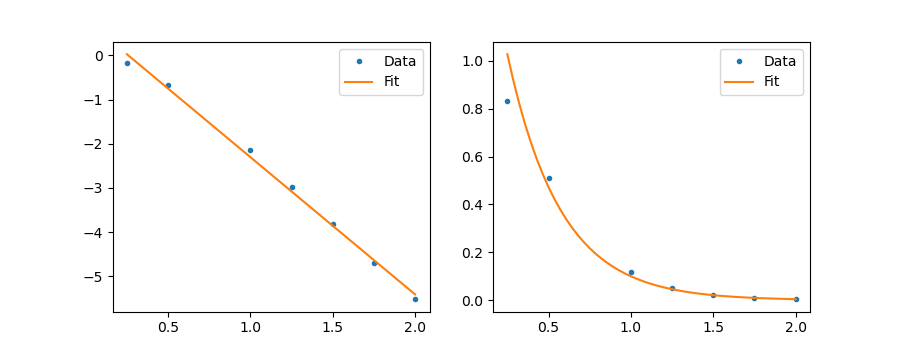

In [ ]:
# First make an note the values of tranmission and the thickness of the barrier.
thickness = np.array([2, 1.75, 1.5, 1.25, 1.0, 0.5, 0.25]) # x-values 
transmission = np.array([0.004, 0.009, 0.022, 0.051, 0.118, 0.511, 0.834]) # y-values
log_T = np.log(transmission) # log of y-values

# We want to fit the logarithm of the y values, as that is a simple linear regression.

# Construct the Matrix that solves, wC = Y -- corresponding to the linear regression A[i] * tau[i]*x[i] = y[i] 
C = np.column_stack([[1]*len(thickness), thickness])

# C_inv = np.linalg.inv(C)
# Solve for the values 
A, tau = np.linalg.solve(C.T@C, C.T@log_T)
print(f"Fit yields:\n A = {A:.3f}\t tau = {tau:.3f}")
log_fit = lambda x: A + tau*x
fit = lambda x: np.exp(log_fit(x))

# print(fit(x))


def curve_fit(X, Y, verbose = False):
    C = np.column_stack([[1]*len(X), X])
    fit_params = np.linalg.solve(C.transpose()@C, C.transpose()@Y)
    if verbose:
        print("Paramters are:")
        for param in fit_params:
            print(param)
    return fit_params
    
fig, ax = plt.subplots(1, 2)

x = np.linspace(0.25, 2) 

ax[0].plot(thickness, log_T, ".", label="Data") # plot the log of transmission
ax[0].plot(x, log_fit(x), label="Fit") # plot the log fit

ax[1].plot(thickness, transmission, ".", label="Data")
ax[1].plot(x, fit(x), label="Fit")

for axis in ax:
    axis.legend()


In [17]:
interactive_type_barrier_transmission(single_barrier, **single_barrier_params)

interactive(children=(Checkbox(value=False, description='clever'), FloatSlider(value=1.0, description='barrier…

### Double barrier <a name="bar2"></a>

In [18]:
double_barrier_params = dict(
    barrier_width=(0.1, 2, 0.1), 
    barrier_w_diff=(0, 2, 0.1), 
    barrier_height=(0.1, 5, 0.1), 
    barrier_sep=(-1,4,0.1), 
    well_potential=(0, 5, 0.1)
)
interactive_type_barrier(double_barrier, **double_barrier_params)

interactive(children=(FloatSlider(value=4.0, description='E', max=8.0, min=0.01, step=0.01), FloatSlider(value…

In [19]:
interactive_type_barrier_transmission(double_barrier, 
                                     **double_barrier_params)

interactive(children=(Checkbox(value=False, description='clever'), FloatSlider(value=1.0, description='barrier…

### Double well <a name="well2"></a>

In [20]:
#double_well(barrier_height, mid_bar_diff, barrier_sep, barrier_width)
double_well_params = dict(
barrier_height=(0.1,5,0.1), mid_bar_diff=(0,5,0.1), barrier_sep=(0,5,0.1), barrier_width=(0.1,4,0.1)
)
interactive_type_barrier(double_well, **double_well_params)

interactive(children=(FloatSlider(value=4.0, description='E', max=8.0, min=0.01, step=0.01), FloatSlider(value…

In [21]:
interactive_type_barrier_transmission(double_well, **double_well_params)

interactive(children=(Checkbox(value=False, description='clever'), FloatSlider(value=2.5000000000000004, descr…

### Multi well <a name="multiwell"></a>

In [24]:
#def multi_well(bar_height, bar_sep, bar_width, num_wells)
mul_params = dict(
    bar_height=(0.1,4,0.1), bar_sep=(0.1,6,0.1), bar_width=(0.1,2,0.1), num_wells=(1,12,1)
)
interactive_type_barrier(multi_well, **mul_params)

interactive(children=(FloatSlider(value=4.0, description='E', max=8.0, min=0.01, step=0.01), FloatSlider(value…

In [23]:
interactive_type_barrier_transmission(multi_well, **mul_params)

interactive(children=(Checkbox(value=False, description='clever'), FloatSlider(value=2.0, description='bar_hei…